In [1]:
import scipy.io as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs

In [2]:
### load INTERPSTACK
file_to_open_INTERPSTACK ='../../data/01_spatial/INTERPSTACK_sep2021_v5.mat'
file_to_open_FLORA ='../../data/01_spatial/FLORA_biome.mat'
mat_contents_INTERP = sp.loadmat(file_to_open_INTERPSTACK)
mat_contents_FLORA = sp.loadmat(file_to_open_FLORA)

CO2 = mat_contents_INTERP['INTERPSTACK'][0][0][0][0]
interp_time = mat_contents_INTERP['INTERPSTACK'][0][0][1][0]
Tair = mat_contents_INTERP['INTERPSTACK'][0][0][2]
runoff = mat_contents_INTERP['INTERPSTACK'][0][0][3]
land = mat_contents_INTERP['INTERPSTACK'][0][0][4]
lat = mat_contents_INTERP['INTERPSTACK'][0][0][5]
gridarea = mat_contents_INTERP['INTERPSTACK'][0][0][9]
biome = mat_contents_FLORA['biome']
biome_CO2 = np.asarray([21, 19, 19, 18,	17,	16,	15,	12,	11,	12,	12,	14,	16,	16,	16,	13,	14,	11,	12,	11,	9,	8]) #matlab outputs
biome_CO2 = biome_CO2 - 1

for ind, bio in enumerate(biome_CO2):
    if ind >= 11:
        biome[:,:,ind] = np.roll(biome[:,:,ind], 24, axis=1)

In [3]:
from scipy.interpolate import interp1d

root_times = np.asarray([600, 410, 400, 350, 0])
root_depths = np.asarray([0, 0, 10, 100, 460])#460 from Canadell et al. 1996 Oecologia

root_interp = interp1d(root_times, root_depths)

In [4]:
timestep =17

root_depth = root_interp(interp_time[timestep]*-1)
root_depth

array(388.)

/var/folders/gs/2q8t31qn5wjb02_tw8sm_c7h0000gn/T/ipykernel_75108/4189166326.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,6))


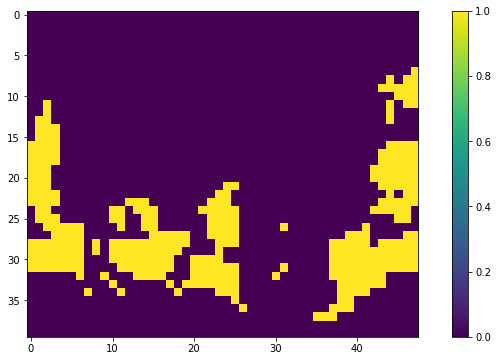

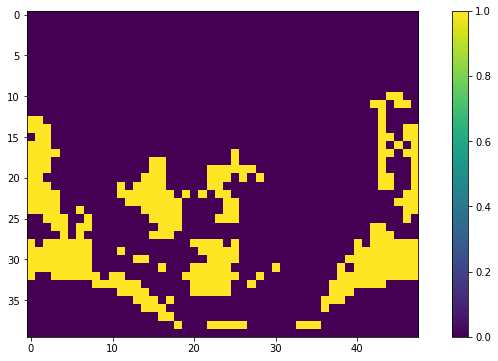

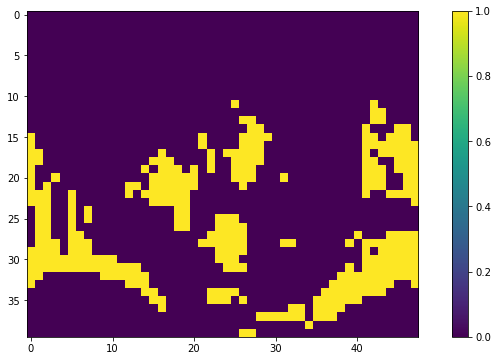

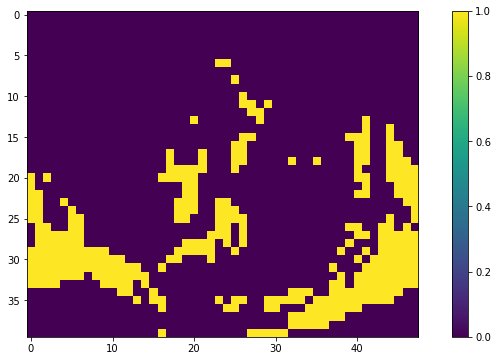

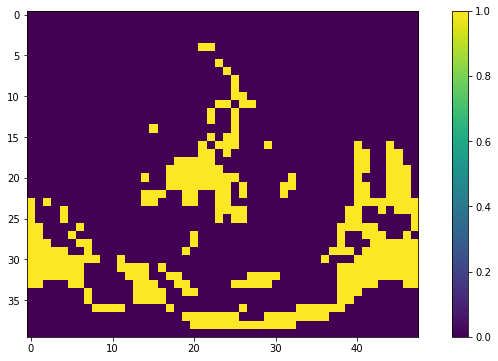

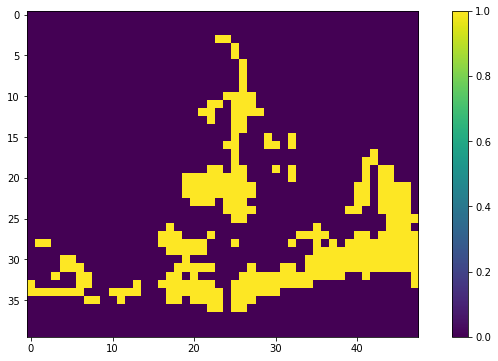

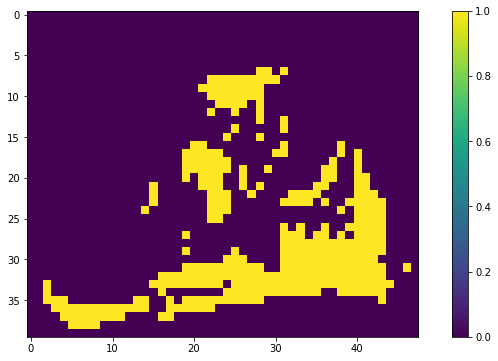

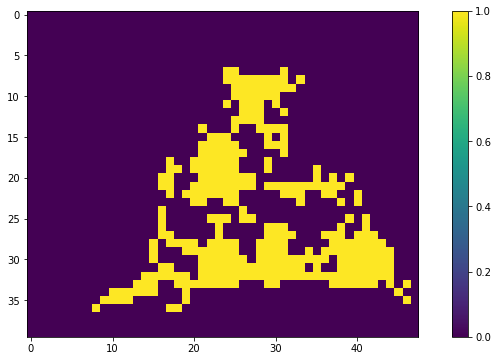

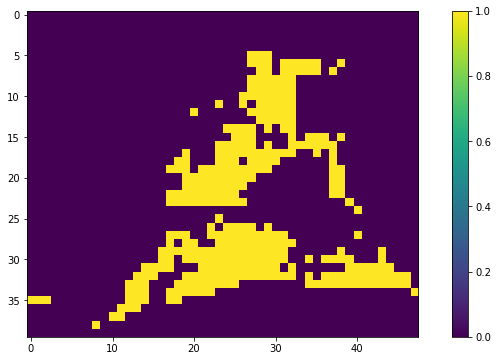

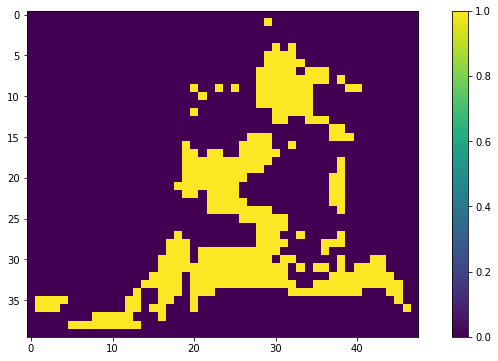

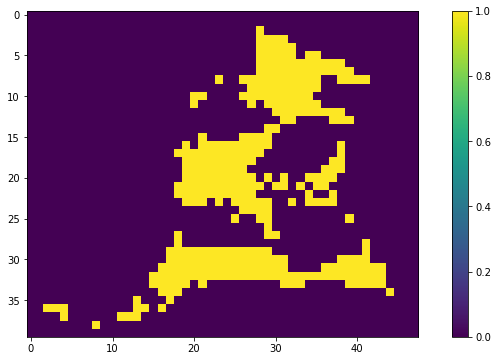

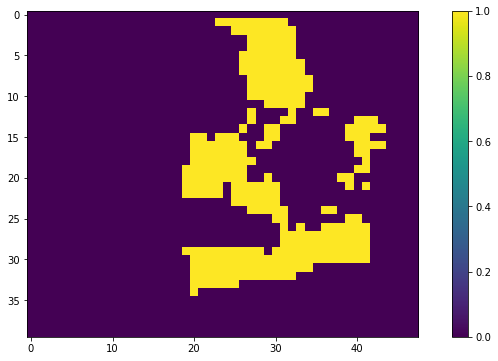

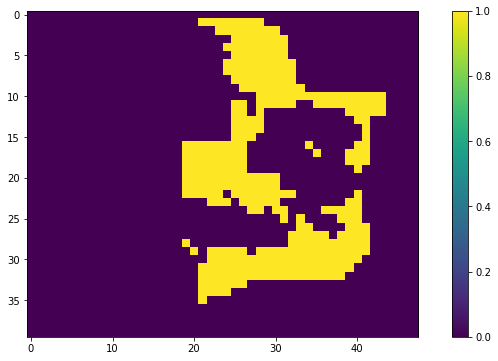

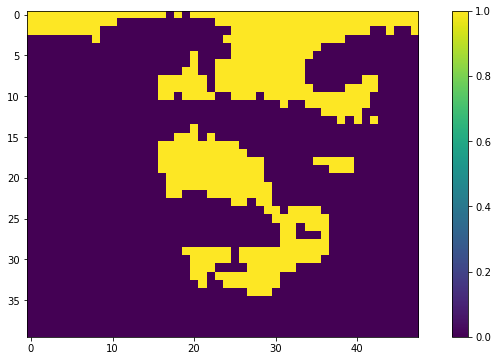

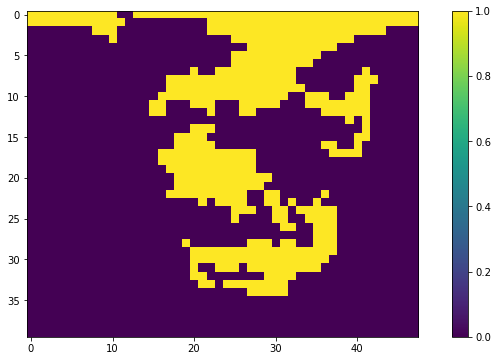

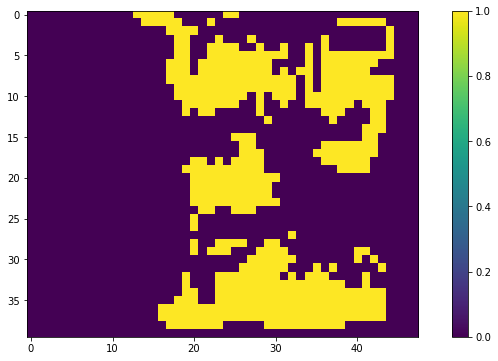

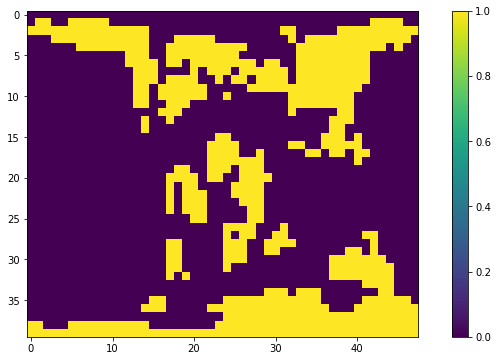

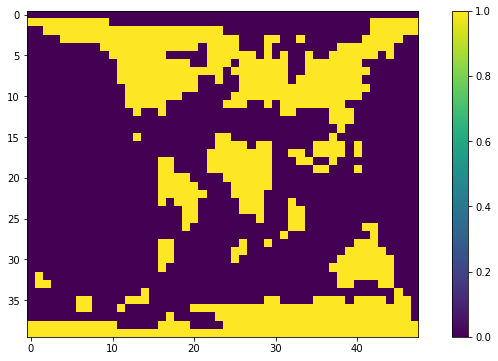

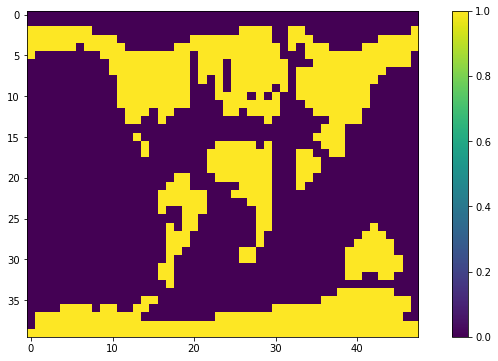

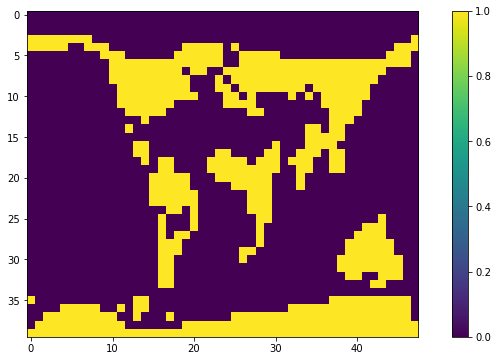

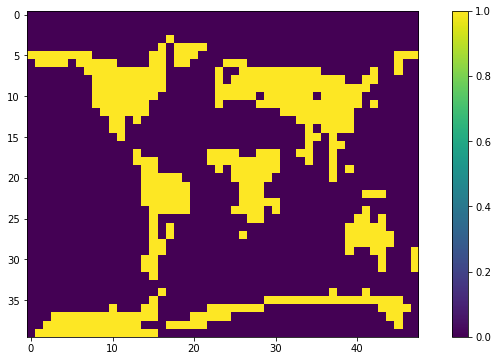

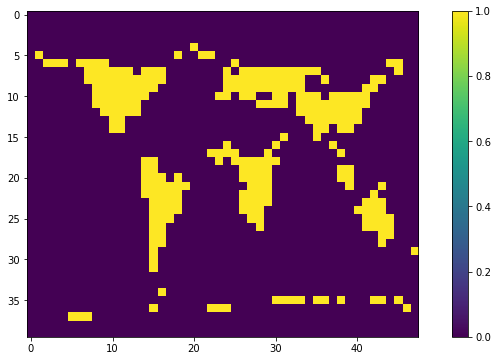

In [6]:

ice_limit_temp = -10
plant_land_sea = np.copy(land)
root_depth_multiplier = np.zeros_like(interp_time)
labels = ['temperate', 'boreal', 'tropical', 'arid', 'ice']
for ind, time in enumerate(interp_time):
    #time = time*-1
    #get biome land sea mask
    #make ice, assume all left over is arid
    plant_land_sea[:,:,ind][biome[:,:,ind] == 4] = 0
    root_depth_multiplier[ind] = root_interp(time*-1)
    #print(time, root_depth)
    
    fig, ax = plt.subplots(figsize=(12,6))
    cax = ax.imshow(plant_land_sea[:,:,ind], cmap='viridis')#, vmax=460)
    fig.colorbar(cax)
    #ax.set_title(f'biome at {interp_time[timestep]} and {CO2[time_CO2]} ppm CO2, {timestep}')
    #np.savetxt(f'../../results/plants_present_{time}_Ma.csv', plant_land_sea[:,:,timestep].astype(int), delimiter=',')
    
    
    

In [7]:
root_depth_maps = plant_land_sea* root_depth_multiplier.T

for ind, time in enumerate(interp_time):
    np.savetxt(f'../../results/root_presence_{time*-1}_Ma.csv', plant_land_sea[:,:,ind].astype(int), delimiter=',')
    np.savetxt(f'../../results/root_depth_{time*-1}_Ma.csv', root_depth_maps[:,:,ind].astype(int), delimiter=',')
    

In [8]:
root_depth_maps.shape

(40, 48, 22)

In [9]:
import scipy
scipy.io.savemat('../../src/SCION_model/forcings/root_presence.mat', {'root_presence': plant_land_sea})

In [10]:
roots = scipy.io.loadmat('../../src/SCION_model/forcings/root_presence.mat')

In [11]:
roots['root_presence'].shape

(40, 48, 22)

540.0 0.0
500.0 0.0
470.0 0.0
450.0 0.0
430.0 0.0
400.0 10.0
370.0 64.0
340.0 110.28571428571433
300.0 151.42857142857144
280.0 172.0
260.0 192.5714285714286
245.0 208.00000000000003
220.0 233.71428571428572
200.0 254.2857142857143
180.0 274.8571428571429
145.0 310.8571428571429
90.0 367.42857142857144
70.0 388.0
52.0 406.51428571428573
30.0 429.14285714285717
15.0 444.57142857142856
0.0 460.0


/var/folders/gs/2q8t31qn5wjb02_tw8sm_c7h0000gn/T/ipykernel_66538/3211277815.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,6))


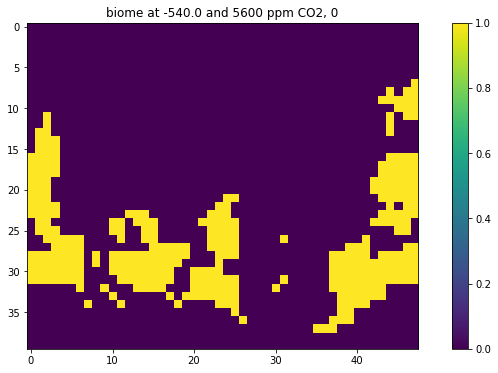

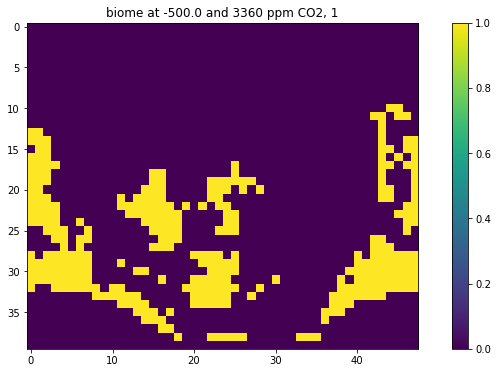

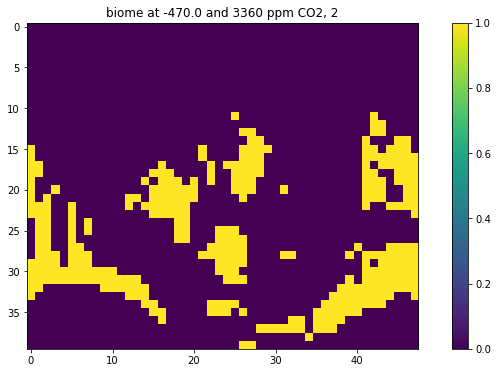

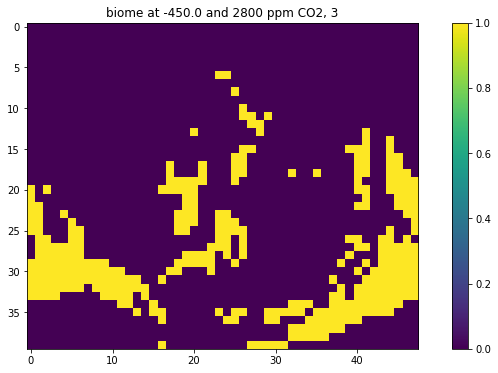

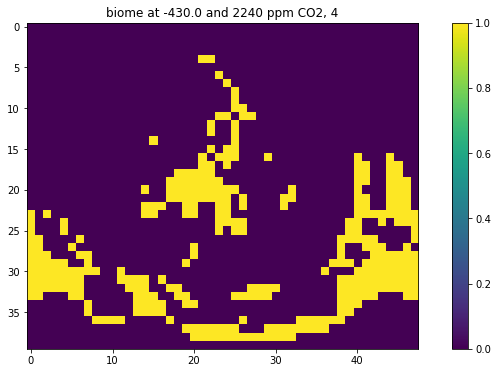

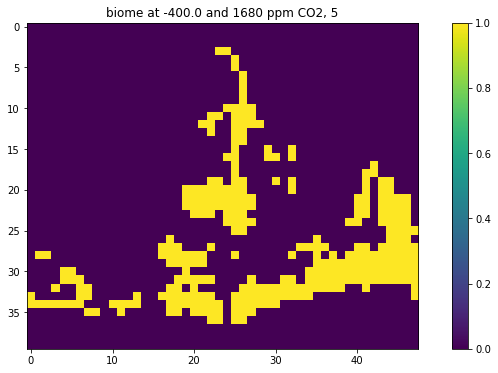

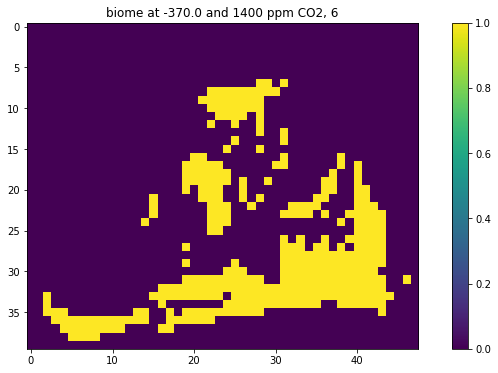

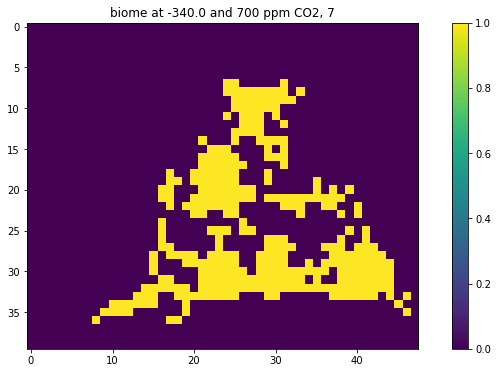

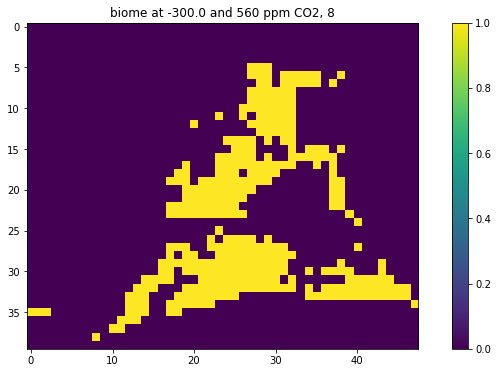

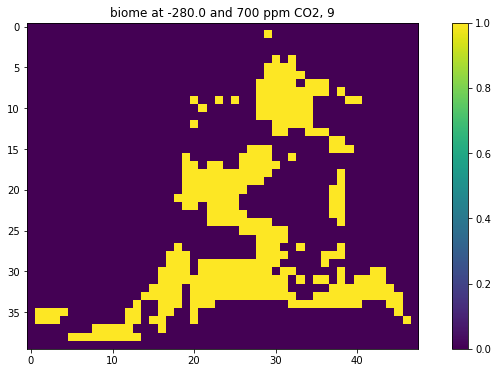

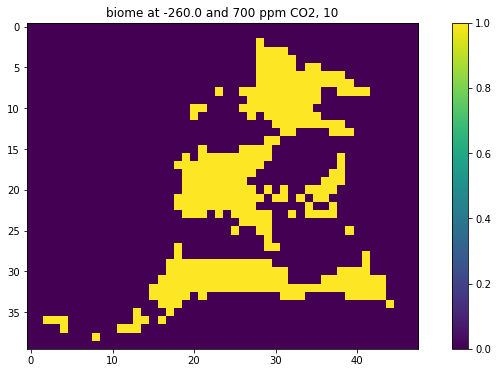

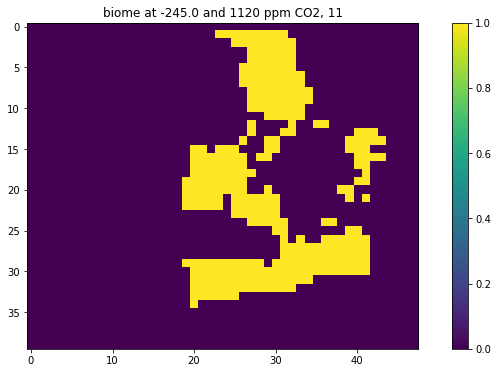

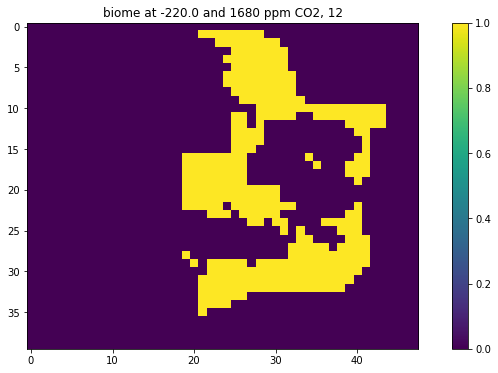

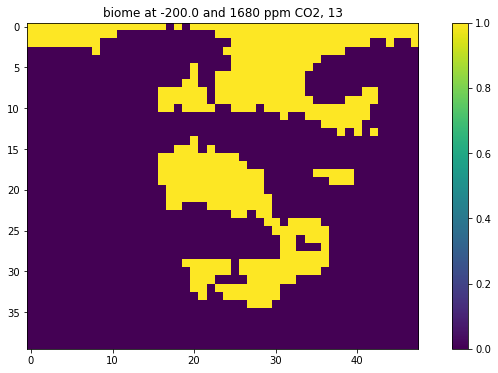

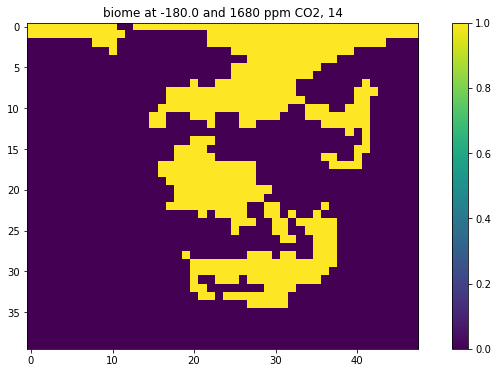

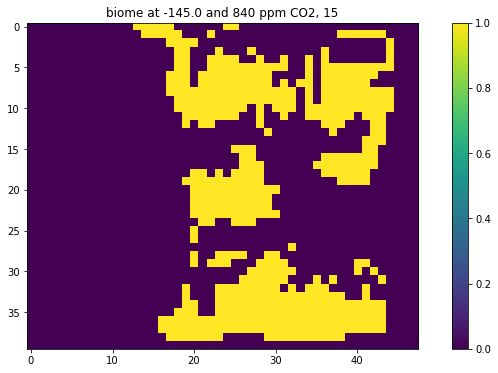

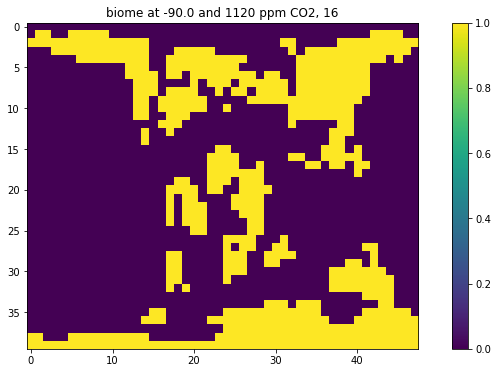

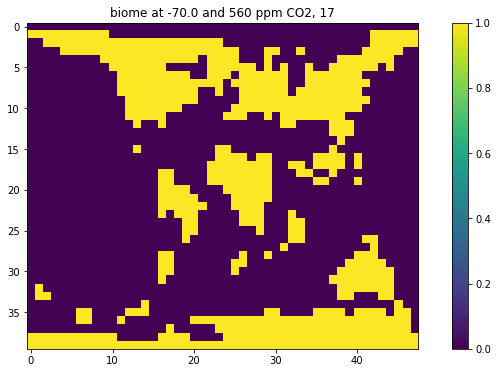

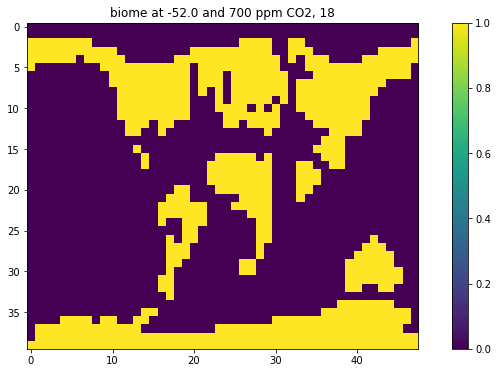

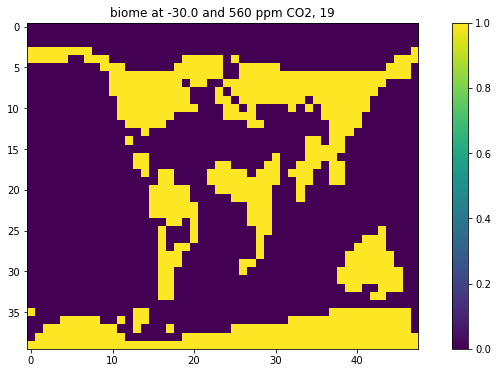

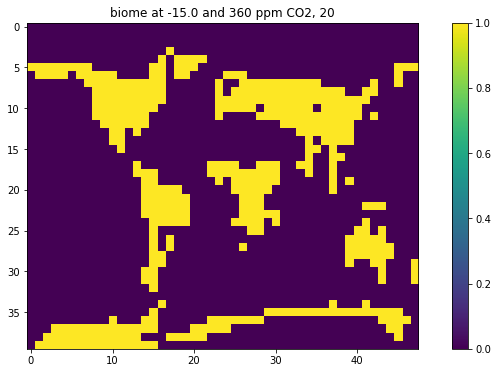

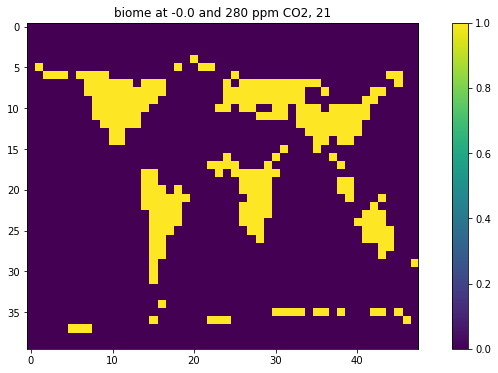

In [5]:

ice_limit_temp = -10
biome_land_sea = np.copy(land)
plant_land_sea = np.copy(land)
biome_fractional_content = np.zeros([22,5])
labels = ['temperate', 'boreal', 'tropical', 'arid', 'ice']
for timestep, time_CO2 in enumerate(biome_CO2[:]):
    time = interp_time[timestep]*-1
    #get biome land sea mask
    biome_land_sea[:,:,timestep] = land[:,:,timestep]*biome[:,:,timestep]
    #make ice, assume all left over is arid
    plant_land_sea[:,:,timestep][biome_land_sea[:,:,timestep] == 4] = 0
    root_depth = root_interp(time)
    print(time, root_depth)
    plant_land_sea[:,:,timestep] * root_depth
    
    biome_land_sea[:,:,timestep][(Tair[:,:,time_CO2,timestep] < ice_limit_temp) & (biome_land_sea[:,:,timestep] == 4)] = 5
    #get total land area at timestep
    total_sum = np.sum(gridarea[land[:,:,timestep] == 1])

    #loop through biomes to get fractional content
    for ind, biome_type in enumerate(np.arange(1,6,1)):
        biome_sum = np.sum(gridarea[biome_land_sea[:,:,timestep] == biome_type])
        biome_fractional_content[timestep, ind] = biome_sum/total_sum
    fig, ax = plt.subplots(figsize=(12,6))
    cax = ax.imshow(plant_land_sea[:,:,timestep], cmap='viridis')#, vmax=460)
    #cbar = fig.colorbar(cax, ticks=[0,1,2,3,4,5], orientation='horizontal')
    #cbar.ax.set_xticklabels(['sea', 'temperate', 'boreal', 'tropical', 'arid', 'ice'])  # horizontal colorbar
    fig.colorbar(cax)
    ax.set_title(f'biome at {interp_time[timestep]} and {CO2[time_CO2]} ppm CO2, {timestep}')
    np.savetxt(f'../../results/plants_present_{time}_Ma.csv', plant_land_sea[:,:,timestep].astype(int), delimiter=',')
    
    
    

In [143]:
#present_day_biome = biome_land_sea[:,:,-1]#.astype(int)
#np.savetxt('../../data/01_spatial/present_day_biome.csv', present_dat_biome, delimiter=',')

present_day_biome = biome_land_sea[:,:,-1]#.astype(int)
np.savetxt('../../data/01_spatial/present_day_biome.csv', present_dat_biome, delimiter=',')

In [181]:
biome_labels = ['temperate', 'boreal', 'tropical', 'arid', 'ice']
biome_coefficient = np.asarray([0.5, 0.2, 0.3, 0.0, 0.0])
biome_dict = dict(zip(biome_labels, biome_coefficient))
biome_fractional_content

array([[0.12012275, 0.20991547, 0.28966973, 0.26248637, 0.11780568],
       [0.10059736, 0.16689031, 0.3302629 , 0.30070124, 0.10154819],
       [0.09234005, 0.14862851, 0.3637178 , 0.29002234, 0.1052913 ],
       [0.11505179, 0.17885997, 0.32088993, 0.30720432, 0.07799399],
       [0.10020264, 0.14802858, 0.34807635, 0.31538286, 0.08830957],
       [0.14501172, 0.14208183, 0.23102486, 0.34726846, 0.13461313],
       [0.16095019, 0.19320557, 0.29851729, 0.29542015, 0.0519068 ],
       [0.16040528, 0.18692245, 0.26172097, 0.2715197 , 0.11943161],
       [0.17038597, 0.22399341, 0.2542305 , 0.23076472, 0.12062541],
       [0.11595477, 0.22685662, 0.22015966, 0.36090219, 0.07612676],
       [0.07754508, 0.22485935, 0.27757752, 0.31300459, 0.10701346],
       [0.06763896, 0.27781111, 0.30626006, 0.22440213, 0.12388773],
       [0.15094203, 0.23828056, 0.33051647, 0.21577368, 0.06448726],
       [0.25266165, 0.16049635, 0.33759201, 0.24924999, 0.        ],
       [0.25825753, 0.11983289, 0.

In [182]:
biome_dict

{'temperate': 0.5, 'boreal': 0.2, 'tropical': 0.3, 'arid': 0.0, 'ice': 0.0}

In [186]:
biome_coefficient*biome_fractional_content

array([[0.06006138, 0.04198309, 0.08690092, 0.        , 0.        ],
       [0.05029868, 0.03337806, 0.09907887, 0.        , 0.        ],
       [0.04617002, 0.0297257 , 0.10911534, 0.        , 0.        ],
       [0.05752589, 0.03577199, 0.09626698, 0.        , 0.        ],
       [0.05010132, 0.02960572, 0.1044229 , 0.        , 0.        ],
       [0.07250586, 0.02841637, 0.06930746, 0.        , 0.        ],
       [0.08047509, 0.03864111, 0.08955519, 0.        , 0.        ],
       [0.08020264, 0.03738449, 0.07851629, 0.        , 0.        ],
       [0.08519298, 0.04479868, 0.07626915, 0.        , 0.        ],
       [0.05797738, 0.04537132, 0.0660479 , 0.        , 0.        ],
       [0.03877254, 0.04497187, 0.08327326, 0.        , 0.        ],
       [0.03381948, 0.05556222, 0.09187802, 0.        , 0.        ],
       [0.07547101, 0.04765611, 0.09915494, 0.        , 0.        ],
       [0.12633083, 0.03209927, 0.1012776 , 0.        , 0.        ],
       [0.12912876, 0.02396658, 0.

In [193]:
biome_modifiers = np.sum(biome_coefficient*biome_fractional_content, axis=1)
np.savetxt('../../results/biome_modifier_rel_PD.csv', biome_modifiers/biome_modifiers[-1], delimiter=',')

In [195]:
from scipy.interpolate import interp1d

biome_INTERP = interp1d(1e6 * interp_time, biome_modifiers/biome_modifiers[-1])

In [190]:
biome_modifiers

array([0.18894539, 0.18275561, 0.18501107, 0.18956487, 0.18412994,
       0.17022968, 0.2086714 , 0.19610342, 0.20626081, 0.16939661,
       0.16701767, 0.18125972, 0.22228207, 0.2597077 , 0.28230369,
       0.25415724, 0.29722824, 0.25393397, 0.27157143, 0.22843649,
       0.21497831, 0.16817469])

In [192]:
interp_time

array([-540., -500., -470., -450., -430., -400., -370., -340., -300.,
       -280., -260., -245., -220., -200., -180., -145.,  -90.,  -70.,
        -52.,  -30.,  -15.,   -0.])

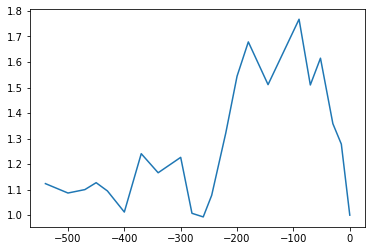

In [191]:
plt.plot(interp_time,biome_modifiers/biome_modifiers[-1])

In [163]:
total_sum = np.sum(gridarea[land[:,:,-1] == 1])
for i in np.arange(1,6,1):
    biome_sum = np.sum(gridarea[biome_land_sea[:,:,-1] == i])
    print(i, biome_sum/total_sum)



1 0.08682247363274763
2 0.23304283550728033
3 0.2605162805560822
4 0.2073471074681002
5 0.21227130283578946


In [157]:
gridarea

array([[24432.65372715, 24432.65372715, 24432.65372715, ...,
        24432.65372715, 24432.65372715, 24432.65372715],
       [55943.17458664, 55943.17458664, 55943.17458664, ...,
        55943.17458664, 55943.17458664, 55943.17458664],
       [87305.4722549 , 87305.4722549 , 87305.4722549 , ...,
        87305.4722549 , 87305.4722549 , 87305.4722549 ],
       ...,
       [87305.4722549 , 87305.4722549 , 87305.4722549 , ...,
        87305.4722549 , 87305.4722549 , 87305.4722549 ],
       [55943.17458664, 55943.17458664, 55943.17458664, ...,
        55943.17458664, 55943.17458664, 55943.17458664],
       [24432.65372715, 24432.65372715, 24432.65372715, ...,
        24432.65372715, 24432.65372715, 24432.65372715]])

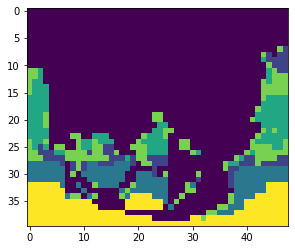

In [148]:

plt.imshow(biome_land_sea[:,:,0])